<!-- --- -->
title: Sparse Observations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, SWOT
---

In [ ]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
# Ensure TF does not see GPU and grab all GPU memory.
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Sparse Observations

In the previous examples, we were demonstrating how NerFs perform when we have some clean simulation. 
However, in many real problems, we do not have access to such clean

For this example, we are going to look at the case when we have very sparse observations: as in the case with satellite altimetry data like SWOT. In this case

In [ ]:
# !wget -nc "https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_nadir_0d_swot.nc"

In [ ]:
from pathlib import Path

In [ ]:
Path(
    "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/dataset_nadir_0d_swot.nc"
).is_file()

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict


@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda: ["2013-01-01", "2013-01-10"])


files = [
    # "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/swot1nadir5.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/nadir4.nc",
]


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    paths: List[str] = field(default_factory=lambda: files)
    batch_size: int = 5_000
    shuffle: bool = True
    train_size: float = 0.90
    # subset_size: float = None
    spatial_coords: List = field(default_factory=lambda: ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda: ["ssh_obs"])


# spatial transform
spatial_transforms = Pipeline(
    [
        ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
        ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
    ]
)

temporal_transforms = Pipeline(
    [
        ("timedelta", TimeDelta("2012-10-01", 1, "s")),
        ("timeminmax", MinMaxDF(["time"], -1, 1)),
    ]
)

In [6]:
# select = {"time": slice("2012-10-22", "2012-11-22")}
select = {"time": slice("2012-10-22", "2012-12-02")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=None,  # spatial_transforms,
    temporal_transform=None,  # temporal_transforms,
)

In [7]:
xrda_obs = dm.load_xrds()
xrda_obs

<xarray.Dataset>
Dimensions:    (time: 23015)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-0...
Data variables:
    ssh_obs    (time) float64 0.975 1.008 1.009 1.009 ... -0.156 -0.1723 -0.1581
    ssh_model  (time) float64 0.9958 1.014 1.027 ... -0.1925 -0.1974 -0.1997
    lon        (time) float64 -55.03 -55.06 -55.1 -55.13 ... -58.03 -58.07 -58.1
    lat        (time) float64 39.58 39.53 39.47 39.42 ... 42.8 42.85 42.9 42.95
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:37:54Z
    date_modified:             2018-10-12T12:37:54Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Evaluation

In [8]:
from dataclasses import dataclass, field
from typing import List, Dict


@dataclass
class SSHDMEVAL:
    _target_: str = "jejeqx._src.datamodules.coords.EvalCoordDM"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    decode_times: bool = True
    evaluation: bool = True
    spatial_coords: List = field(default_factory=lambda: ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda: ["sossheig"])
    coarsen: Dict = field(default_factory=lambda: {"lon": 4, "lat": 4})
    resample: str = "1D"

In [9]:
%%time

config_dm = OmegaConf.structured(SSHDMEVAL())

dm_eval = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=dm.spatial_transform,
    temporal_transform=dm.temporal_transform,
)

CPU times: user 10.1 ms, sys: 26 µs, total: 10.1 ms
Wall time: 10.2 ms


In [10]:
%%time

xrnatl60 = dm_eval.load_xrds()
xrnatl60

CPU times: user 13.1 s, sys: 2.71 s, total: 15.8 s
Wall time: 1min 7s


<xarray.Dataset>
Dimensions:   (time: 42, lat: 150, lon: 150)
Coordinates:
  * lon       (lon) float64 -64.96 -64.89 -64.83 -64.76 ... -55.16 -55.09 -55.03
  * lat       (lat) float64 33.04 33.11 33.17 33.24 ... 42.77 42.84 42.91 42.97
  * time      (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    sossheig  (time, lat, lon) float32 0.6505 0.659 0.6661 ... -0.2041 -0.2134
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [11]:
import pandas as pd
from tqdm.auto import tqdm, trange

t_buffer = np.timedelta64(7, "D")
ts = xrnatl60.time.values

In [12]:
dt = ts[1] - ts[0]

vtime = (xrda_obs.time.values - xrda_obs.time.values[0]) / dt
vts = (ts - ts[0]) / dt

xrda_obs["vtime"] = (("time"), vtime)

In [13]:
import gpjax as gpx
from gpjax import Dataset
import optax

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
def init_sgp_model(D):
    
    # kernel = gpx.RBF(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
    kernel = gpx.Matern52(active_dims=[0,1,2], lengthscale=jnp.array([7.0, 1.0, 1.0]))
    meanf = gpx.mean_functions.Zero()
    prior = gpx.Prior(mean_function=meanf, kernel=kernel)
    
    likelihood = gpx.Gaussian(num_datapoints=D.n)

    posterior = prior * likelihood
    
    return posterior


def fit_sgp_model(posterior, D, z, **kwargs):
    
    q = gpx.CollapsedVariationalGaussian(posterior=posterior, inducing_inputs=z)
    
    key = jrandom.PRNGKey(123)
    
    negative_elbo = jax.jit(gpx.CollapsedELBO(negative=True))

    optimiser = optax.adam(learning_rate=1e-2)

    opt_posterior, history = gpx.fit(
        model=q,
        objective=negative_elbo,
        train_data=D,
        optim=optimiser,
        num_iters=kwargs.pop("num_iters", 500),
        key=key,
        
    )
    
    return opt_posterior, history


def get_grid(da, time):
    lon = da.lon.values
    lat = da.lat.values

    T, X, Y = np.meshgrid(time, lat, lon, indexing="ij")
    T, X, Y = T.ravel(), X.ravel(), Y.ravel()

    return np.stack([T, X, Y], axis=-1)


def create_coord_dataframe(X, y):
    X = np.asarray(X)
    y = np.asarray(y)[:, None]

    data = np.hstack([X, y])

    df = pd.DataFrame(data, columns=["time", "lat", "lon", "ssh"])
    return df


def predict_batches(X, y):
    return out

In [15]:
from sklearn.cluster import KMeans


def init_inducing_kmeans(x: Array, n_inducing: int, seed: int = 123, **kwargs) -> Array:
    # conver to numpy array
    x = np.array(x)

    # calculate k-means
    clf = KMeans(n_clusters=n_inducing, random_state=seed, n_init="auto", **kwargs).fit(
        x
    )

    # convert to jax array
    x_u_init = jnp.array(clf.cluster_centers_)

    return x_u_init

In [27]:
xrda_gp = xr.Dataset()
num_time = len(vts)
num_inducing = 100
params = None
num_iters = 500
subset = None # 5_000
rng = np.random.RandomState(123)
opt_posterior = None

with trange(num_time) as pbar:
    for i in pbar:
        ivt, it = vts[i], ts[i]

        sub = xrda_obs.where(np.abs(xrda_obs.time - it) < t_buffer, drop=True)

        lat, lon, time, y = (
            sub.lat.values,
            sub.lon.values,
            sub.vtime.values,
            sub.ssh_obs.values,
        )

        pbar.set_description(f"Time: {it} | Num Points: {len(lat):,}")

        # create training input vector
        x = np.stack([time, lat, lon], axis=-1)
        
        
        # initialize GP
        if subset is not None:
            idx = rng.choice(np.arange(x.shape[0]),size=(subset))
                
            x = x[idx]
            y = y[idx]
        
        D = Dataset(x, y[:, None])
        
        # initialize GP
        if opt_posterior is None:
            posterior = init_sgp_model(D)
        else:
            posterior = opt_posterior.posterior
        
        z = init_inducing_kmeans(x=x, n_inducing=num_inducing, seed=123)
        
        
        

        opt_posterior, history = fit_sgp_model(posterior=posterior, D=D, z=z, num_iters=num_iters)
        
        # get grid at current time step
        X_star = get_grid(xrnatl60, ivt)

        def predict_batches(X_star):
            out = list()
            for ix in np.split(X_star, 10):
                
                latent_dist = opt_posterior.predict(ix, train_data=D)
                predictive_mean = latent_dist.mean()

                out.append(predictive_mean)

            out = np.hstack(out)

            return out

        # predict at current time step
        soln = predict_batches(X_star)

        # create coordinate dataframe
        df = create_coord_dataframe(X_star, soln)
        df["time"] = it

        # append dataset
        xrda_gp = xr.merge(
            [xrda_gp, df.set_index(["time", "lat", "lon"]).to_xarray()],
        )

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
xrnatl60["ssh_sgp"] = xrda_gp.ssh

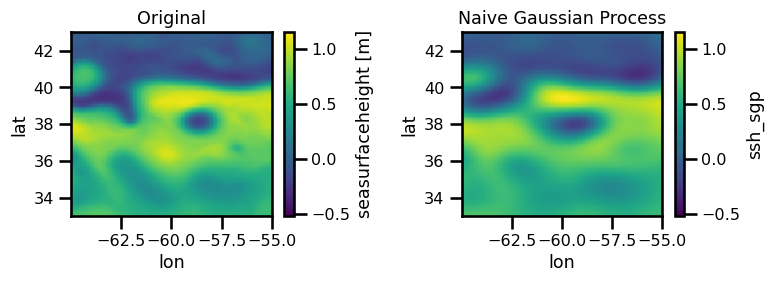

In [31]:
%matplotlib inline

itime = 10

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

vmin = np.min([xrnatl60.sossheig.min(), xrnatl60.ssh_sgp.min()])
vmax = np.min([xrnatl60.sossheig.max(), xrnatl60.ssh_sgp.max()])

xrnatl60.sossheig.sel(time="2012-10-22").plot.pcolormesh(
    ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[0].set(title="Original")

xrnatl60.ssh_sgp.sel(time="2012-10-22").plot.pcolormesh(
    ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[1].set(title="Naive Gaussian Process")

plt.tight_layout()
plt.show()

In [32]:
import common_utils as cutils

In [33]:
ds_rff = cutils.calculate_physical_quantities(xrnatl60.ssh_sgp)
ds_natl60 = cutils.calculate_physical_quantities(xrnatl60.sossheig)

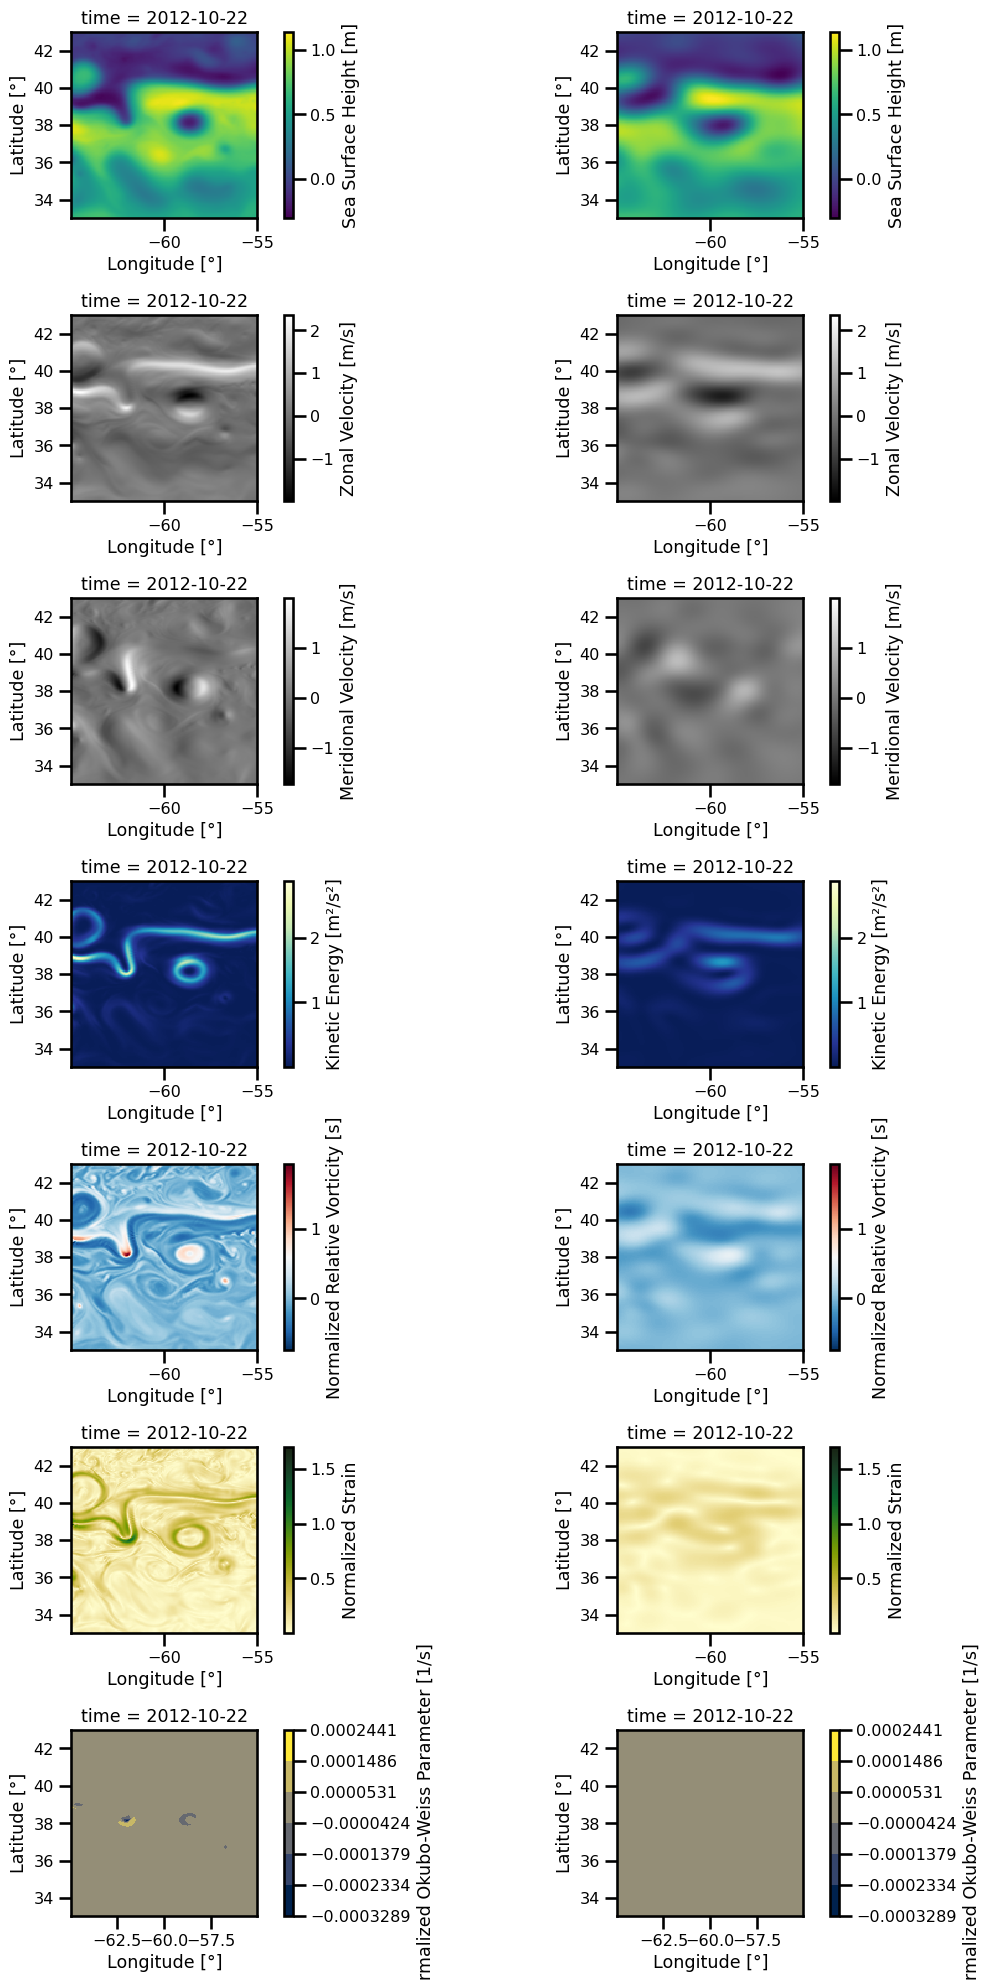

In [34]:
fig, ax = cutils.plot_analysis_vars(
    [
        ds_natl60.sel(time="2012-10-22"),
        ds_rff.sel(time="2012-10-22"),
    ]
)
plt.show()

In [25]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rff = cutils.calculate_isotropic_psd(ds_rff)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

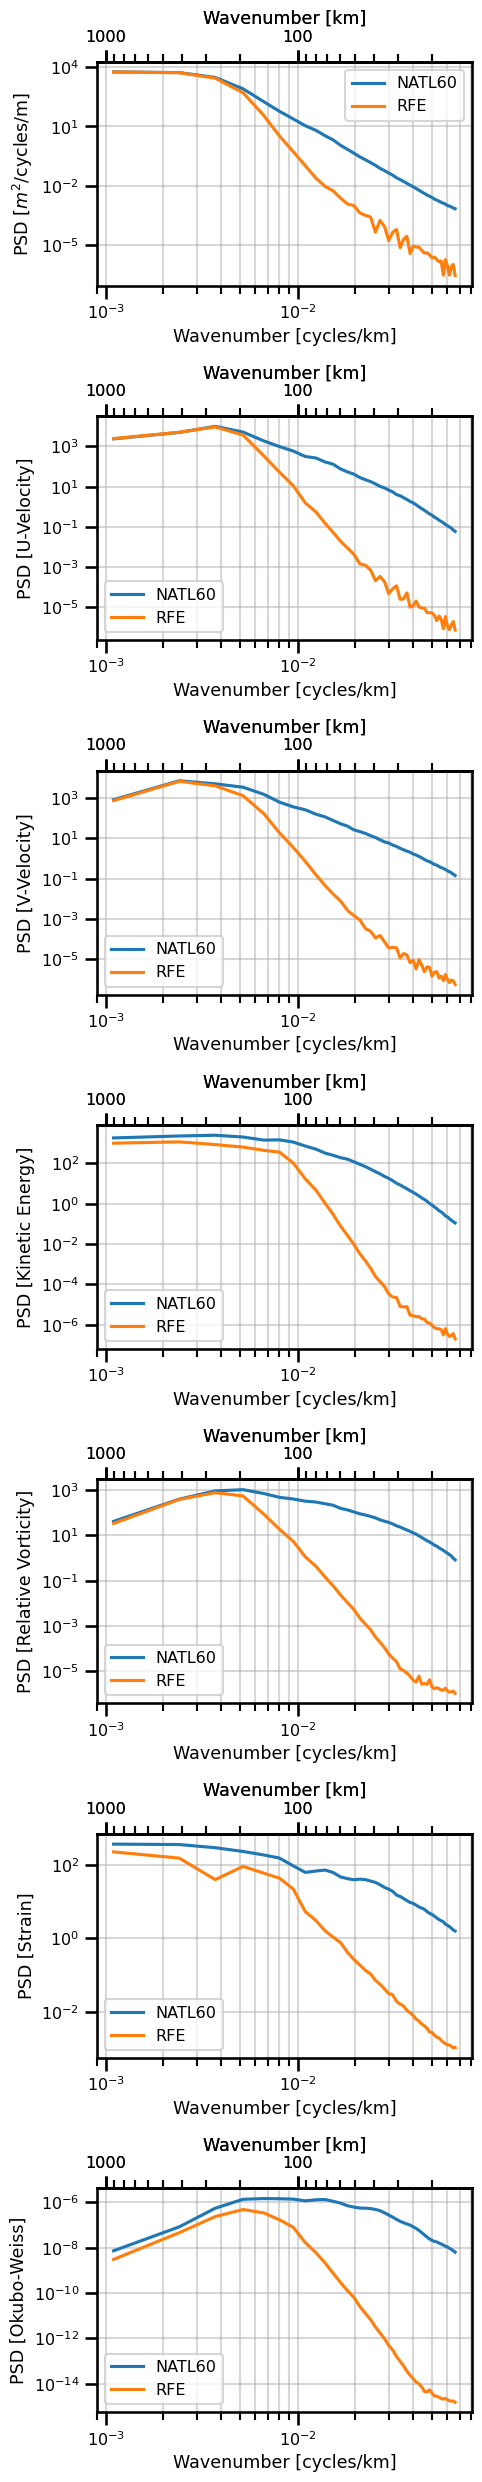

In [26]:
fig, ax = cutils.plot_analysis_psd_iso(
    [
        ds_psd_natl60,
        ds_psd_rff,
    ],
    [
        "NATL60",
        "RFE",
    ],
)
plt.show()

In [ ]:
ds_scores = cutils.calculate_isotropic_psd_score(ds_rff, ds_natl60)

In [ ]:
cutils.plot_analysis_psd_iso_score([ds_scores], ["SGP"], ["k"])
plt.show()

In [ ]:
ds_psd_natl60 = cutils.calculate_spacetime_psd(ds_natl60)
ds_psd_rff = cutils.calculate_spacetime_psd(ds_rff)

In [ ]:
fig, ax = cutils.plot_analysis_psd_spacetime(
    [
        ds_psd_natl60,
        ds_psd_rff,
    ],
    [
        "NATL60",
        "RFE",
    ],
)
plt.show()

In [ ]:
ds_psd_rff = cutils.calculate_spacetime_psd_score(ds_rff, ds_natl60)

In [ ]:
for ivar in ds_psd_rff:
    resolved_spatial_scale = ds_psd_rff[ivar].attrs["resolved_scale_space"] / 1e3
    print(f"Resolved Scale [km]: {resolved_spatial_scale:.2f} [{ivar.upper()}]")
    resolved_temporal_scale = ds_psd_rff[ivar].attrs["resolved_scale_time"]
    print(f"Resolved Scale [days]: {resolved_temporal_scale:.2f}  [{ivar.upper()}]")

In [ ]:
_ = cutils.plot_analysis_psd_spacetime_score([ds_psd_rff], ["rff"])